In [25]:
import functions as fx
import log_reg_functions as lrf
import loaddata as ld
import NeuralNetwork as nn

import numpy as np
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import log_loss, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neural_network import MLPRegressor

# D
Creating the Franke function with noise.

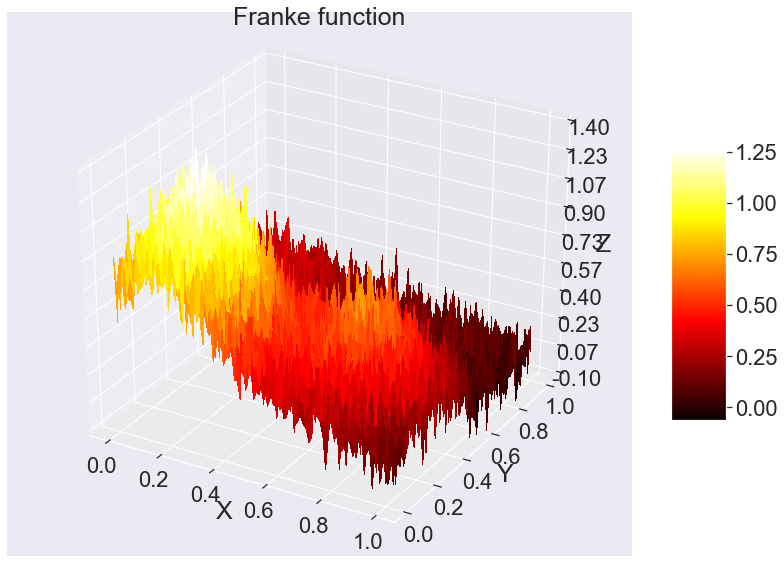

(10000, 21)
(10000, 19)


In [26]:
n=100
x = np.linspace(0,1,n)
y = x
x_mesh, y_mesh  = np.meshgrid(x,y)
noise_level     = 0.1
frank           = fx.FrankeFunction(x_mesh, y_mesh, noise_level)

from matplotlib import cm 
from matplotlib.ticker import LinearLocator, FormatStrFormatter 

from mpl_toolkits.mplot3d import Axes3D 
fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, frank, cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

frank=frank.ravel()
frank=frank.reshape([len(frank),1])
design=fx.DesignDesign(x,y,5)
print(design.shape)
design=np.delete(design, [0,1], axis=1)
print(design.shape)



test loss for η = 0.001 & λ = 0.0 = 0.046643250864835346


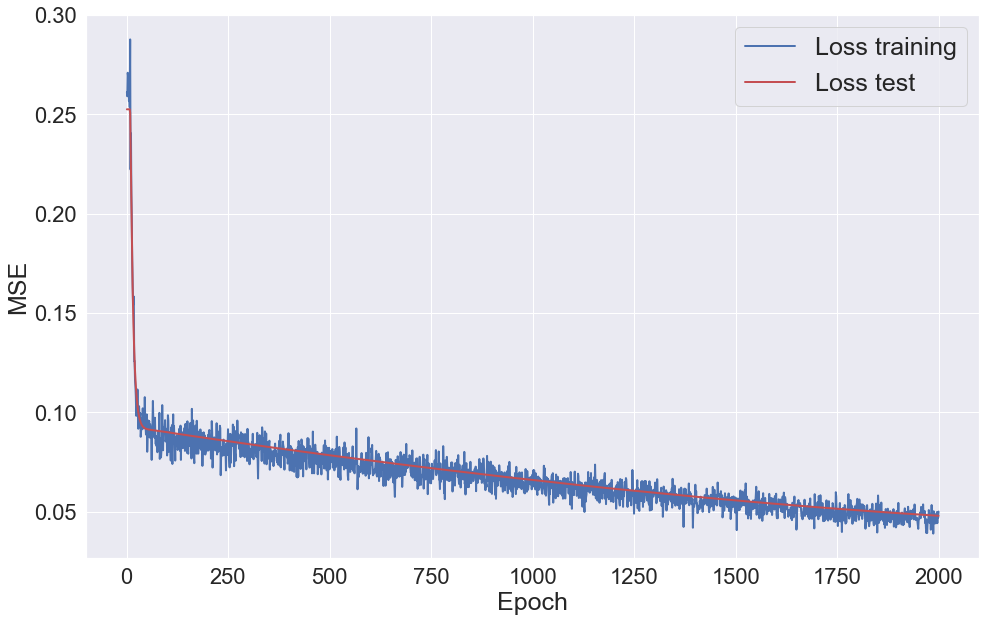

test loss for η = 0.001 & λ = 1e-05 = 0.04666165493943006


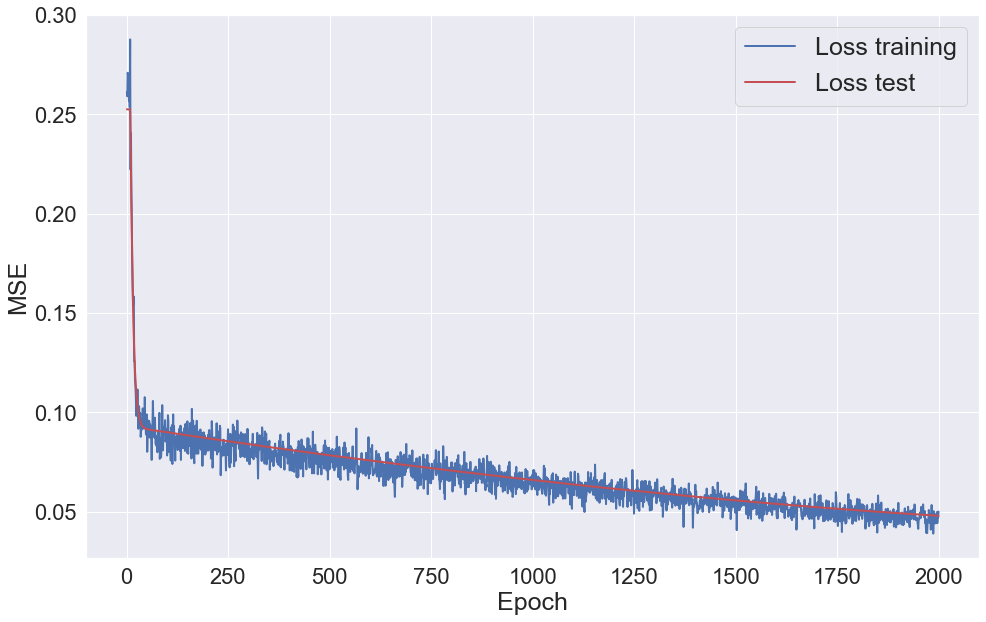

test loss for η = 0.001 & λ = 0.0001 = 0.046827528691129536


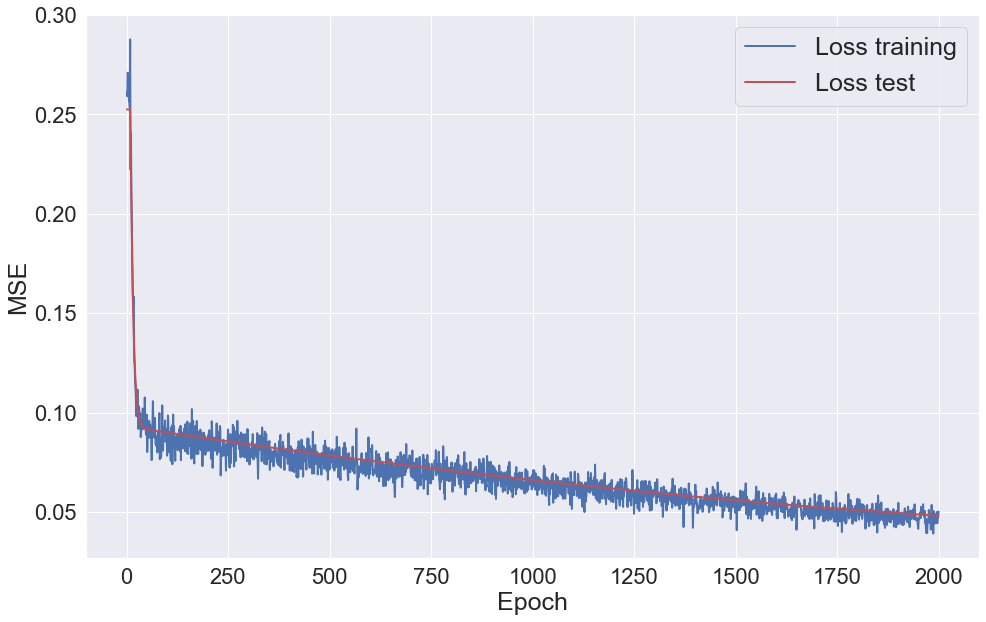

test loss for η = 0.001 & λ = 0.001 = 0.048507766530655104


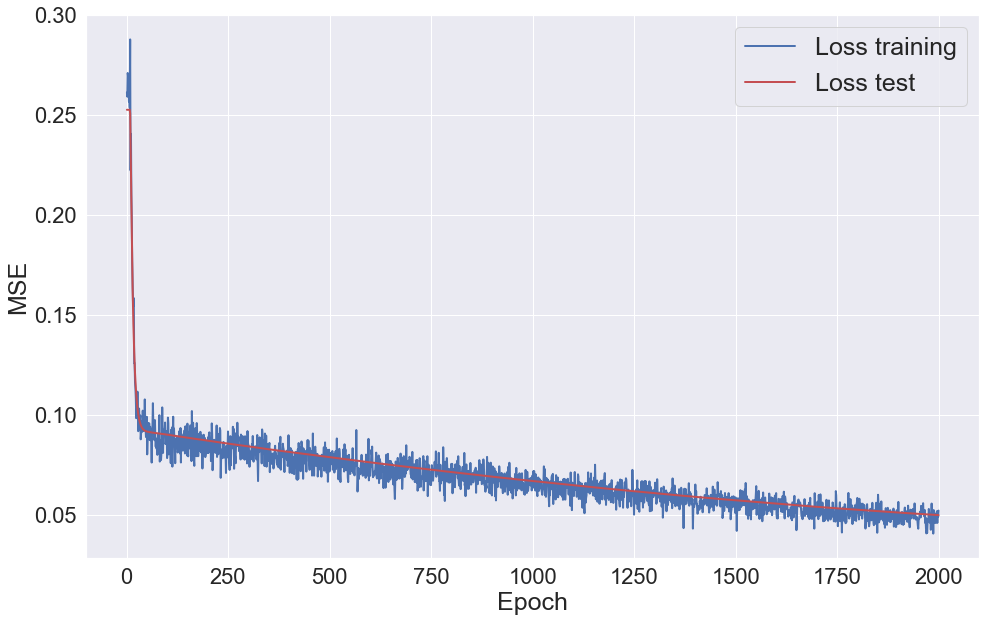

test loss for η = 0.01 & λ = 0.0 = 0.027905939040327427


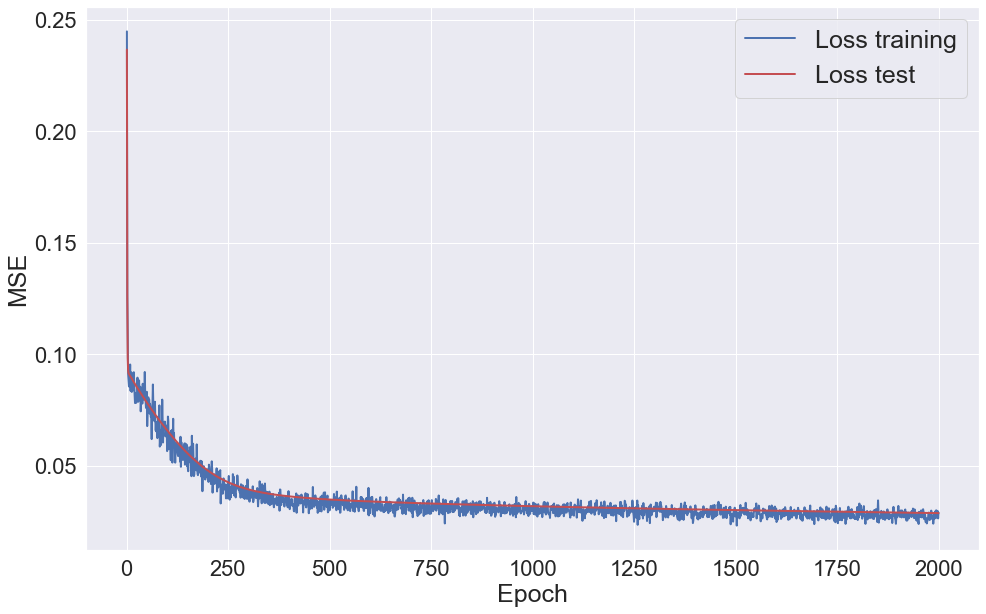

In [ ]:
epochs=2000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.logspace(-3, -1, 3)
lmbvec = np.logspace(-6, -3, 4)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=2000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)
        cost_test, cost_train = neural_net.costs()

        sns.set(font_scale=2)
        plt.figure(figsize=([16,10]))
        axis = np.arange(len(cost_train))+1
        plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
        plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
        plt.legend(fontsize=25)
        plt.ylabel('MSE',fontsize=25)
        plt.xlabel('Epoch',fontsize=25)
        plt.show()
test_loss = test_loss/k
test_r2 = test_r2/k

In [ ]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_loss, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [ ]:
yticklabels = etavec
xticklabels = lmbvec
fig, ax = plt.subplots(figsize = (10, 12))
sns.heatmap(test_r2, annot=True, ax=ax, cmap="viridis",\
            yticklabels=yticklabels, xticklabels=xticklabels)
#ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$", fontsize=20)
ax.set_xlabel("$\lambda$", fontsize=20)
tmp = np.arange(len(etavec))+0.5
tmp[0] = 0
tmp[-1]+=0.5
ax.set_yticks(tmp)
tmp = np.arange(len(lmbvec)) + 0.5
ax.set_xticks(tmp)
plt.show()

In [ ]:
epochs=2000
batch_size=int(len(frank)/20)
n_features=design.shape[1]
etavec = np.linspace(0.05, 0.15, 11)
lmbvec = np.logspace(-6, -5, 1)
lmbvec[0]=0
k=5
activation = [lrf.sigmoid, lrf.sigmoid, lrf.relu]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.relu_deriv]



y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss = np.zeros((len(etavec), len(lmbvec)))
test_r2 = np.zeros((len(etavec), len(lmbvec)))
for i, etas in enumerate(etavec):
    for j, lmb in enumerate(lmbvec):
        
        for kf in range(k):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=lmb, bias=0, eta=etas,early_stop_tol = 0,\
                                early_stop_nochange=2000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=False)

            pred = neural_net.feed_out(xtest, activation)
            test_loss[i,j] +=  fx.MSE(pred.ravel(),ytest.T)
            test_r2[i,j] +=  fx.R2Score(pred.ravel(),ytest.T)
            
        print('test loss for', '\u03B7 =', etas, '&', '\u03BB =', lmb, '=', test_loss [i,j]/k)
        cost_test, cost_train = neural_net.costs()

        sns.set(font_scale=2)
        plt.figure(figsize=([16,10]))
        axis = np.arange(len(cost_train))+1
        plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
        plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
        plt.legend(fontsize=25)
        plt.ylabel('MSE',fontsize=25)
        plt.xlabel('Epoch',fontsize=25)
        plt.show()

test_loss = test_loss/k
test_r2 = test_r2/k

In [ ]:
best_eta_index, best_lmb_index = np.where(test_loss == np.min(test_loss))
best_eta,best_lmb = etavec[best_eta_index], lmbvec[best_lmb_index] 
print('eta=',best_eta)
print('lmb=',best_lmb)

In [ ]:
k=5
y_folds, x_folds = lrf.k_fold_reshaper(k,frank,design,shuffle=True)
test_loss_best = 0
test_r2_best = 0
n_features=design.shape[1]

activation = [lrf.sigmoid, lrf.sigmoid, lrf.nooutact]
derivative = [lrf.sigmoid_deriv, lrf.sigmoid_deriv, lrf.nooutact_deriv]
epochs= 4000
for kf in range(1):
            xtrain = x_folds[np.arange(len(x_folds))!=kf]      # Featch all but the i-th element
            xtrain = np.concatenate(xtrain,axis=0)
            ytrain = y_folds[np.arange(len(y_folds))!=kf]
            ytrain = np.concatenate(ytrain,axis=0)
            xtest  = x_folds[kf]
            ytest  = y_folds[kf]
            
            np.random.seed(2019)
            neural_net = nn.ANN(lmb=best_lmb, bias=0, eta=best_eta,early_stop_tol = 0,\
                                early_stop_nochange=4000, mode = 'regression', regularization = 'l1')            
            neural_net.add_layers(n_features=[n_features,20,10], n_neurons = [20,10,1] , n_layers=3)

            neural_net.train(epochs, batch_size, xtrain,ytrain,activation,derivative \
                             ,xtest,ytest, verbose=True)

            pred = neural_net.feed_out(xtest, activation)
            test_loss_best +=  fx.MSE(ytest.ravel(),pred.ravel())
            test_r2_best +=  fx.R2Score(ytest.ravel(),pred.ravel())

test_loss_best /= 1
test_r2_best /= 1
cost_test, cost_train = neural_net.costs()
print(test_r2_best, 'r2 score')
print(test_loss_best, 'MSE')
            

In [ ]:
cost_test, cost_train = neural_net.costs()

sns.set(font_scale=2)
plt.figure(figsize=([16,10]))
axis = np.arange(len(cost_train))+1
plt.plot(axis, cost_train, 'b', label='Loss training', linewidth=2)
plt.plot(axis, cost_test, 'r', label='Loss test', linewidth=2)
plt.legend(fontsize=25)
plt.ylabel('MSE',fontsize=25)
plt.xlabel('Epoch',fontsize=25)
plt.show()

In [ ]:
pred = neural_net.feed_out(design, activation)


fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
ax.view_init(elev=40., azim=-45)

#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred.ravel()))

In [ ]:
desig = fx.DesignDesign(x,y,5)

beta, pred = fx.OridinaryLeastSquares(desig, frank, desig)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
ax.view_init(elev=40., azim=-45)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

fx.R2Score(frank,desig@beta)



In [ ]:
design=fx.DesignDesign(x,y,8)
design=np.delete(design, [0,1], axis=1)

X_train = design
Y_train = frank.ravel()

n_hidden_neurons = (45,30)
epochs = 1000
eta_vals = np.logspace(-2, -1, 2)
lmbd_vals = np.logspace(-5, 1, 7)
DNN_scikit = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
sns.set()
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=lmbd, learning_rate_init=eta, max_iter=epochs)
        dnn.fit(X_train, Y_train)
        DNN_scikit[i][j] = dnn
        train_accuracy[i][j] = dnn.score(X_train, Y_train)
        print(train_accuracy[i][j])
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
plt.show()

In [ ]:
best_eta_index, best_lmb_index = np.where(train_accuracy == np.max(train_accuracy))
best_eta,best_lmb = eta_vals[best_eta_index], lmbd_vals[best_lmb_index] 
print(best_eta, 'eta')
print(best_lmb, 'lmb') 


dnn = MLPRegressor(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',
                            alpha=best_lmb, learning_rate_init=best_eta, max_iter=epochs*100)
dnn.fit(X_train, Y_train)
DNN_scikit = dnn
train_accuracy = dnn.score(X_train, Y_train)
print(train_accuracy)

In [ ]:
pred = dnn.predict(X_train)

fig         = plt.figure(figsize=(14,10)) 
ax          = fig.gca(projection='3d')
surf        = ax.plot_surface(x_mesh, y_mesh, pred.reshape([n,n]), cmap='hot', linewidth=0, antialiased=False)
ax.set_zlim(-0.10, 1.40) 
ax.zaxis.set_major_locator(LinearLocator(10)) 
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel('X', fontsize=25)
ax.set_ylabel('Y', fontsize=25)
ax.set_zlabel('Z', fontsize=25)
#plt.title('Franke function', fontsize=25, y=1.05)# Add a color bar which maps values to colors. 
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


print(fx.R2Score(frank.ravel(),pred))